In [1]:
!pip install keras-tuner
from google.colab import drive
import pandas as pd
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/rainfall_se_clean.csv')
df.head()
df.set_index('Date', inplace=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
import time, numpy as np, tensorflow as tf
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self._epoch_start = None
        self.train_start = time.perf_counter()
    def on_epoch_begin(self, epoch, logs=None):
        self._epoch_start = time.perf_counter()
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.perf_counter() - self._epoch_start)
    def on_train_end(self, logs=None):
        self.total_train_time = time.perf_counter() - self.train_start
def measure_training_time(model, x_train, y_train, *, epochs=50, batch_size=128, val_split=0.1, callbacks=()):
    th = TimeHistory()
    hist = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=val_split,
        verbose=0,
        callbacks=[*callbacks, th],
    )
    return {
        "history": hist,
        "total_train_s": th.total_train_time,
        "mean_epoch_s": float(np.mean(th.epoch_times)),
        "median_epoch_s": float(np.median(th.epoch_times)),
    }
@tf.function
def _predict_graph(model, x):
    return model(x, training=False)
def measure_inference_time(model, x, *, batch_size=128, repeats=5, take_n=100):
    _ = model.predict(x[:batch_size], batch_size=batch_size, verbose=0)
    xs = x[:take_n]
    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = model.predict(xs, batch_size=batch_size, verbose=0)
        times.append(time.perf_counter() - t0)
    mean = float(np.mean(times))
    return {
        "per_100_samples_s": mean,
        "per_sample_ms": mean * 1000.0 / take_n,
    }

In [3]:
import tempfile, os, pathlib
def model_size_bytes(model):
    with tempfile.TemporaryDirectory() as d:
        path = pathlib.Path(d) / "tmp_model.keras"
        model.save(path, include_optimizer=False)
        return os.path.getsize(path)
def describe_model_complexity(model):
    params = model.count_params()
    return {
        "params": int(params)
    }

In [4]:
import numpy as np
seq_len = 90
rainfall_series = df[['Value_log']].values.astype('float32')
split = int(len(rainfall_series) * 0.8)
train_series = rainfall_series[:split]
test_series = rainfall_series[split:]
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_series)
test_scaled = scaler.transform(test_series)
def create_sequences(data, sequence_len):
    a, b = [], []
    for i in range(len(data) - sequence_len):
        a.append(data[i:i+sequence_len])
        b.append(data[i+sequence_len])
    return np.array(a), np.array(b)
x_train, y_train = create_sequences(train_scaled, seq_len)
x_test, y_test = create_sequences(test_scaled, seq_len)
x_train = x_train.reshape(-1, seq_len, 1)
x_test = x_test.reshape(-1, seq_len, 1)

In [5]:
def build_model(hp, seq_len):
    units1 = hp.Int('units1', min_value=32, max_value=256, step=32)
    units2 = hp.Int('units2', min_value=0, max_value=256, step=32)
    use_bi = hp.Boolean('bi', default = False)
    drop = hp.Float('drop', min_value=0.0, max_value=0.4, step=0.1)
    lr = hp.Float('lr', min_value=1e-4, max_value=5e-3, sampling='log')
    input = keras.layers.Input((seq_len, 1))
    lstm1 = keras.layers.LSTM(units1, return_sequences=True)
    x = keras.layers.Bidirectional(lstm1)(input) if use_bi else lstm1(input)
    if units2 > 0:
        x = keras.layers.LSTM(units2, return_sequences = True)(x)
    query = keras.layers.Lambda(lambda x: x[:, -1:, :])(x)
    context = keras.layers.Attention(use_scale=True)([query, x])
    context = keras.layers.Flatten()(context)
    if drop > 0:
      context = keras.layers.Dropout(drop)(context)
    output = keras.layers.Dense(1, activation='linear')(context)
    model = keras.Model(inputs=input, outputs=output)
    model.compile(loss=Huber(), optimizer=Adam(learning_rate=lr))
    return model
y_train = y_train.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr = 1e-6)
tunning = kt.BayesianOptimization(
    lambda hp: build_model(hp, seq_len = x_train.shape[1]),
    objective='val_loss',
    max_trials=15,
    executions_per_trial=1,
    directory='tuner_dir_LSTM',
    project_name='rainfall_LSTM'

)
tunning.search(x_train, y_train, validation_split=0.1, epochs=100, batch_size=128, callbacks = [early_stopping, rlr], verbose = 1)
best_model = tunning.get_best_models(num_models=1)[0]

Trial 15 Complete [00h 01m 43s]
val_loss: 0.020271549001336098

Best val_loss So Far: 0.01990305259823799
Total elapsed time: 00h 20m 11s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [7]:
loss = best_model.evaluate(x_test, y_test)
print(f"Test Loss (MSE): {loss}")
best_hps = tunning.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0195
Test Loss (MSE): 0.019765108823776245
Best Hyperparameters: {'units1': 128, 'units2': 160, 'bi': True, 'drop': 0.4, 'lr': 0.003517743064181451}


In [8]:
y_pred = best_model.predict(x_test)
y_pred_log = scaler.inverse_transform(y_pred)
y_test_log = scaler.inverse_transform(y_test.reshape(-1, 1))

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [11]:
best_hps = tuner.get_best_hyperparameters(1)[0]
model = build_model(best_hps)
timing_train = measure_training_time(
    model, x_train, y_train,
    epochs=50,
    batch_size=128,
    val_split=0.1,
    callbacks=[early_stopping, rlr],
)
timing_infer = measure_inference_time(model, x_test, batch_size=128, repeats=5, take_n=100)
complexity = describe_model_complexity(model)
print("Training time (total s):", timing_train["total_train_s"])
print("Mean epoch time (s):", timing_train["mean_epoch_s"])
print("Inference per 100 samples (s):", timing_infer["per_100_samples_s"])
print("Per-sample inference (ms):", timing_infer["per_sample_ms"])
print("Params:", complexity["params"])

Training time (total s): 61.90433341900007
Mean epoch time (s): 2.812915512136421
Inference per 100 samples (s): 0.11425230519989782
Per-sample inference (ms): 1.1425230519989782
Params: 400162
Model size (MB): 4.634


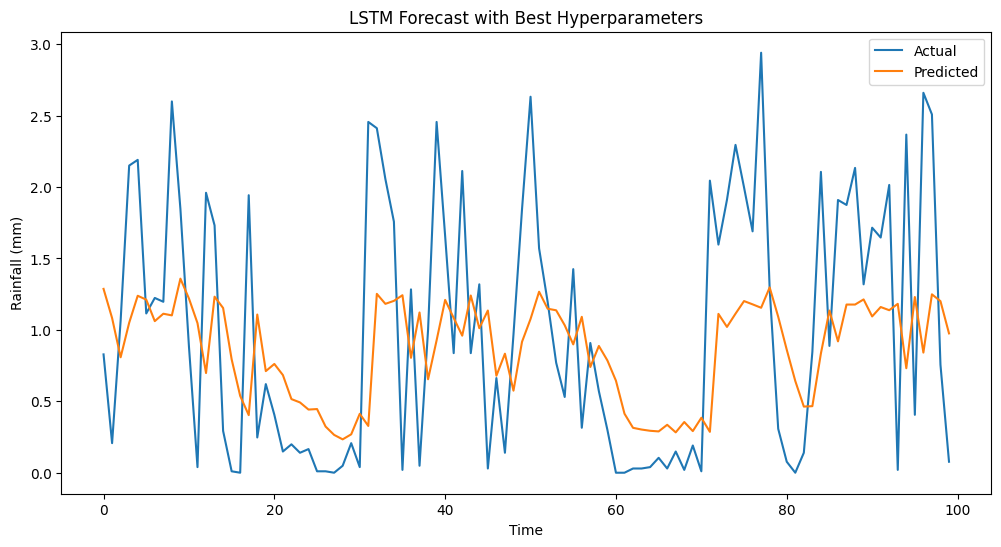

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot((y_test_log)[:100], label='Actual')
plt.plot((y_pred_log)[:100], label='Predicted')
plt.title("LSTM + Attention Forecast with Best Hyperparameters")
plt.xlabel("Time")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test_log, y_pred_log)
print(f"MAE: {mae:.4f} mm")
rmse = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
print(f"RMSE: {rmse:.4f} mm")
r2 = r2_score(y_test_log, y_pred_log)
print(f"R² Score: {r2:.4f}")

MAE: 0.5897 mm
RMSE: 0.7489 mm
R² Score: 0.1951


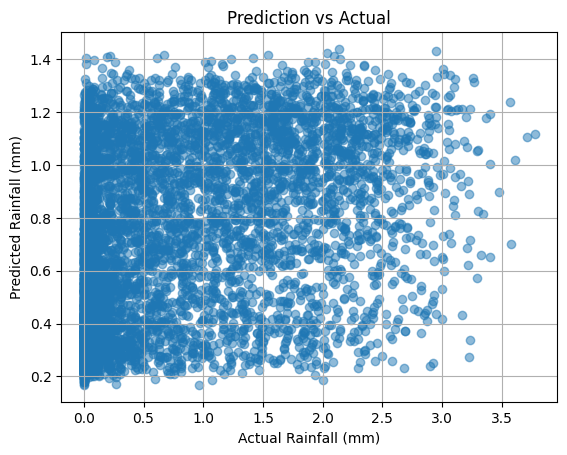

In [ ]:
plt.scatter(y_test_log, y_pred_log, alpha=0.5)
plt.xlabel("Actual Rainfall (mm)")
plt.ylabel("Predicted Rainfall (mm)")
plt.title("Prediction vs Actual")
plt.grid(True)
plt.show()